In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

First you need to build the graph in networkX.  Barabasi-Albert graphs are supposed to be similar to human networks.

In [2]:
pop_size = 50000
# pop = nx.barabasi_albert_graph(pop_size, 10, seed = 5)
pop = nx.powerlaw_cluster_graph(pop_size, m=7, p = .2, seed=8)

We need to choose an initial infected person.  You can start with more infected people, but need to make edits below.

In [3]:
first = np.random.randint(pop_size-pop_size//5)+pop_size//5

This is where you set up initial parameters for the transmition.

In [202]:
N = 150      # number of iterations to run simulation for
N_max = 20  #The hard cap of the number of people a person can interact with in a day 
             #this can be edited during run to simulate social distancing
p=.2        #The percentage of persons contacts they interact with
             #this can be edited during run to simulate social distancing
    
symp_days = 6    # number of time steps until symptoms appear
start_cont_days = 4  # number of time steps until contagious starts
cont_days = 12    # number of time steps from contraction to not contagious
cure_days = 20   # number of time steps from contraction to being cured
mortality_rate = 0.03   # overall mortality rate

N_rand_test = 2000    # number of random tests per day


p_trans = .125   # probability an interaction results in an infection


p_asymp = .2           # percentage of population with no symptoms
p_mild = .6            # percentage of population with mild symptoms (death rate = 0)
p_severe = .15         # percentage of population with severe symptoms (death rate half critical)
p_critical = .05       # percentage of population with critical symptoms (death rate twice severe)

####################
# next we include probabilities that people with different severity remove themselves from contagious pool
# this could be due to self quarintine, hospitalization, enforced quarintine etc

p_asymp_rem = 0         # these people dont know they have symptoms so they wont isolate because of them
p_mild_rem = 0.5        # only some of these people will remove
p_severe_rem = .9       # most of these people remove on day 1 of symptoms (default 90%) by day 2 almost all (default 99%)
p_critical_rem = 1.     # everyone (default) removes on day 1


# Used in calculating death rate for different scenario assuming critical twice as deadly as severe
mr = [0,0,mortality_rate/(p_severe+2*p_critical),2*mortality_rate/(p_severe+2*p_critical)]  

if mr[0]*p_asymp+p_mild*mr[1]+p_severe*mr[2]+p_critical*mr[3]==mortality_rate:
    pass
else:
    print('changes to mr are incompatible with the overall mortality rate. Fix this before continuing.')

death_prob = np.exp(np.log(1-np.array(mr))/(cure_days-symp_days))  # This is used to simulate death

if p_asymp+p_mild+p_severe+p_critical ==1:
    pass
else:
    print('severity probabilities do not sum to 1. Fix this before continuing.')

cont = np.zeros((N,))     # where number of contagious each time step people are stored
infect = np.zeros((N,))  # where number of infected each time step people are stored
cured = np.zeros((N,))   # where number of cured each time step people are stored
dead = np.zeros((N,))  # where number of dead each time step people are stored
R0 = np.zeros((N,))  # where average number of infections per contagious person is stored
test_pos = np.zeros((N,))  # where number of people who have tested positive is stored

p_rem = [p_asymp_rem,p_mild_rem,p_severe_rem,p_critical_rem]   # packaging the remove probs for easier use

######
#  Using p_var you can simulate the effects of temperature
#  This messy function simulates resurgence 
# p_var = ((np.tanh(-1*np.sin(3.14*(np.arange(N)-N/4)/(N/3)))+1)/2*1/2+1/2)*p_trans*.95+1.1*(np.tanh(-1*np.sin(3.14*(np.arange(N)+N/2)/N))+1)*p_trans/4

p_var = np.ones(N)*p_trans

In [203]:
####
# Setting attributes

nx.set_node_attributes(pop, 0,'condition')          # tracker for how many time steps since infection
nx.set_node_attributes(pop, 0,'contagious')         # 1 contagious 0 not contagious
nx.set_node_attributes(pop, 0,'dead')
nx.set_node_attributes(pop, 0,'day_infect') 
nx.set_node_attributes(pop, 0,'N_infect')           # tracker for how many people this person has infected 
nx.set_node_attributes(pop, 0,'severity')           # 0 = asymptomatic, 1 = mild, 2 = severe, 3 = critical
nx.set_node_attributes(pop, 0,'confirmed')           
# 2 = has tested positive but cured/removed, 1 = test positive and actively sick, 0 everything else

######
# Setting initial patients.  You can repeat this for multiple nodes if you want multiple seed patients

pop.node[first]['condition'] = start_cont_days      # first person starts out contagious
pop.node[first]['contagious'] = 1
pop.node[first]['severity'] = 1                     # first person has mild symptoms


np.random.seed(seed=10)       # for reproducibility



for i in range(N):
    l = [x for x,y in pop.nodes(data=True) if y['contagious']==1]   # list of everyone contagious
    L = [x for x,y in pop.nodes(data=True) if ((y['condition']>=symp_days)&(y['condition']<=cure_days))] # list of people with symptoms
    L2 = [x for x,y in pop.nodes(data=True) if ((y['condition']>0)&(y['condition']<start_cont_days))] # list of people infected but not contagious
    L3 = [x for x,y in pop.nodes(data=True) if (y['condition']>0)]  # list of everyone who has ever been sick
    infect[i] = len([x for x,y in pop.nodes(data=True) if y['condition']>0])
    cont[i] = len(l)
    cured[i] = len([x for x,y in pop.nodes(data=True) if y['condition']>=cure_days])
    dead[i] = len([x for x,y in pop.nodes(data=True) if y['dead']==1])
    test_pos[i] = len([x for x,y in pop.nodes(data=True) if y['confirmed'] == 1])
    #######
    # here you can institute social policies 
    if infect[i]>pop_size//100:
        N_max = N_max
    else:
        pass
    
    p_trans = p_var[i]

    ######
    # This is where interactions cause new patients
    for a in l:
        temp = np.minimum(np.random.randint(low=0,high = int(len(list(pop.neighbors(a)))*2*p)+1),N_max)
        l2 = np.random.choice(list(pop.neighbors(a)),temp, replace=False)
        for j in l2:
            if pop.node[j]['condition'] == 0:         # these people are not already sick 
                if np.random.uniform()<p_trans:       # interaction caused infection
                    pop.node[j]['condition'] = 1
                    pop.node[j]['contagious'] = 1
                    pop.node[j]['day_infect'] = i
                    r_temp = np.random.uniform()
                    if r_temp<p_asymp:
                        pop.node[j]['severity'] = 0
                    elif r_temp<(p_mild+p_asymp):
                        pop.node[j]['severity'] = 1
                    elif r_temp<(p_mild+p_severe+p_asymp):
                        pop.node[j]['severity'] = 2
                    else:
                        pop.node[j]['severity'] = 3
                    pop.node[a]['N_infect'] +=1       # for keeping track of how many infections someone caused
                    
                else:                                 # interaction did not caused infection
                    pass
            else:            # these people were already sick 
                pass
            
    for a in l:
        R0[i] += pop.node[a]['N_infect']/len(l)
        
            
    ################
    # This is where random testing happens
    L4 = [x for x,y in pop.nodes(data=True) if y['confirmed'] == 0 and y['dead'] != 1]
    l4 = np.random.choice(L4, N_rand_test, replace=False)
    for k in l4:
        if pop.node[k]['condition'] ==0:    # this person has never been sick
            pass
        elif pop.node[k]['condition'] >= cure_days:   # this person was already sick, but has been cured
            pop.node[k]['confirmed'] = 2
        else:
            pop.node[k]['contagious'] = 0     # this person gets quarintined if they are contagious
            pop.node[k]['confirmed'] = 1      # this is now a confirmed case
            
    ######
    # This is where people become contagious
    for a in L2:
        if pop.node[a]['condition']<start_cont_days:
            pass
        # This person becomes contagious because the disease was not noticed beforehand
        elif pop.node[a]['condition']==start_cont_days and pop.node[a]['confirmed']==0:  
            pop.node[a]['contagious'] = 1
        # This person doesnt become contagious because their case was caught beforehand, but they can still have complications
        elif pop.node[a]['condition']==start_cont_days and pop.node[a]['confirmed']==1:
            pass
        else:
            print('error')
                

    ######
    # This is where people stop being contagious
    for a in l:
        if pop.node[a]['condition'] < cont_days:
            pass
        else:
            pop.node[a]['contagious'] = 0

            
    for a in L:
        temp = np.random.uniform()
        if temp< p_rem[pop.node[a]['severity']]:
            pop.node[a]['contagious'] = 0
        else:
            pass
    


    for a in L:
        temp = np.random.uniform()
        if temp>death_prob[pop.node[a]['severity']]:
            pop.node[a]['contagious'] = 0
            pop.node[a]['dead'] = 1
            pop.node[a]['confirmed'] = 2
        else:
            pass

    for a in L3:
        if pop.node[a]['dead'] == 1:
            pass
        elif pop.node[a]['condition']>= cure_days:
            pop.node[a]['confirmed'] = 2
            pop.node[a]['condition'] += 1
        else:
            pop.node[a]['condition'] += 1
            



In [174]:
# first run
cont0 = cont
infect0 = infect
cured0 = cured

In [200]:
# second run
cont1 = cont
infect1 = infect
cured1 = cured

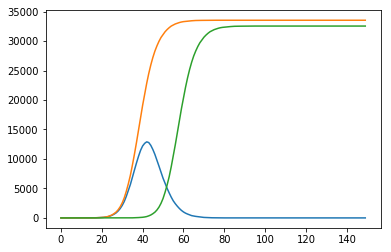

In [181]:
plt.plot(cont)
plt.plot(infect)
plt.plot(cured)


[Text(0.5, 0, 'time steps')]

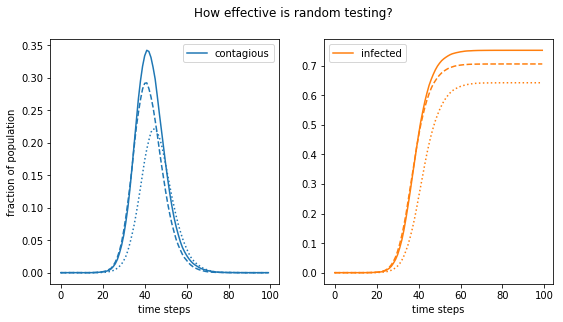

In [204]:
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols = 2, figsize=(9, 4.5))
fig.suptitle('How effective is random testing?')
ax1.plot(cont0[:100]/pop_size, 'C0', label = 'contagious')
ax1.plot(cont1[:100]/pop_size, 'C0--')
ax1.plot(cont[:100]/pop_size, 'C0:')
ax1.legend()
ax1.set(xlabel='time steps', ylabel='fraction of population')

ax2.plot(infect0[:100]/pop_size,'C1',label = 'infected')
ax2.plot(infect1[:100]/pop_size, 'C1--')
ax2.plot(infect[:100]/pop_size, 'C1:')
# ax2.plot(cured0[:100]/pop_size,'C2',label = 'cured')
# ax2.plot(cured1[:100]/pop_size, 'C2--')
# ax2.plot(cured[:100]/pop_size, 'C2:')
ax2.legend()
ax2.set(xlabel='time steps')

In [190]:
infect.max()

2.0

/Users/michaelspillane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/michaelspillane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


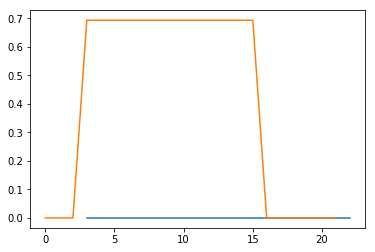

In [189]:
plt.plot(np.log(test_pos))
plt.plot(np.log(infect-cured-dead))

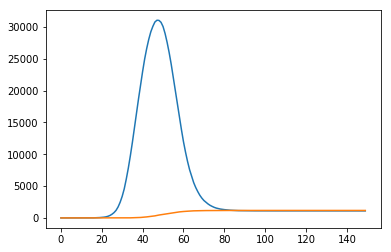

In [153]:
plt.plot(infect-cured)
plt.plot(dead)

In [94]:
(np.array(list(sev.values()))==0).mean(),(np.array(list(sev.values()))==1).mean(),(np.array(list(sev.values()))==2).mean(),(np.array(list(sev.values()))==3).mean()

(0.32286, 0.51058, 0.12638, 0.04018)

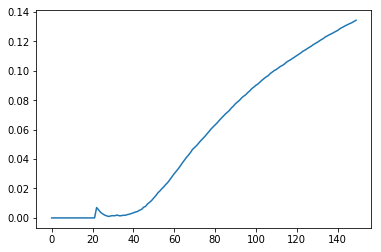

In [94]:
plt.plot(dead/infect)

In [160]:
[x for x,y in pop.nodes(data=True) if y['confirmed'] == 1]

[]

In [145]:
pop.node[52]

{'condition': 14,
 'contagious': 0,
 'dead': 1,
 'N_infect': 10,
 'severity': 2,
 'confirmed': 1,
 'day_infect': 30}

In [109]:
len([x for x,y in pop.nodes(data=True) if (y['condition']>0)])

36469

In [110]:
infect[-1]

36469.0

In [211]:
day_infect=np.array(list(nx.get_node_attributes(pop,'day_infect').values()))

(array([0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 8.000e+00,
        7.000e+00, 1.400e+01, 2.000e+01, 3.600e+01, 3.500e+01, 6.400e+01,
        9.600e+01, 1.220e+02, 1.800e+02, 2.250e+02, 3.160e+02, 4.050e+02,
        5.620e+02, 7.400e+02, 8.910e+02, 1.029e+03, 1.254e+03, 1.407e+03,
        1.599e+03, 1.798e+03, 1.925e+03, 1.874e+03, 1.880e+03, 1.918e+03,
        1.777e+03, 1.602e+03, 1.471e+03, 1.282e+03, 1.138e+03, 9.870e+02,
        8.600e+02, 7.550e+02, 6.710e+02, 5.470e+02, 4.680e+02, 4.090e+02,
        3.290e+02, 2.680e+02, 1.810e+02, 1.740e+02, 1.500e+02, 1.220e+02,
        9.100e+01, 9.200e+01, 5.900e+01, 5.500e+01, 5.500e+01, 3.700e+01,
        2.800e+01, 1.600e+01, 1.300e+01, 1.200e+01, 4.000e+00, 6.000e+00,
        4.000e+00, 6.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        4.000e+00, 1.000e+00, 0.000e+0

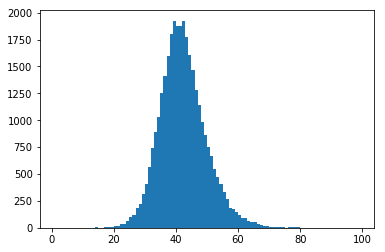

In [215]:
plt.hist(day_infect,bins = np.arange(1,100))

In [210]:
nx.get_node_attributes(pop,'day_infected')

{}

In [214]:
infect[:10]

array([1., 1., 1., 2., 4., 4., 4., 4., 4., 4.])